<a href="https://colab.research.google.com/github/Muhammad-Abdullah-Jami/BERT-LLM/blob/main/AG_News_Dataset_with_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install transformers[torch] --upgrade
# !pip install accelerate --upgrade
# !pip install datasets
# !pip install datasets pandas
!pip install ipywidgets


In [ ]:
!nvidia-smi


Sun Aug 11 07:46:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**Importing libraries**

In [ ]:
import torch
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import files
import os
import ipywidgets as widgets
from IPython.display import display
import torch
import matplotlib.pyplot as plt
import seaborn as sns



Dataset Name: AG News

Task: Text classification

Source: The dataset was derived from the AG's news
corpus, which consists of over 1 million news articles collected from various online sources.

The AG News dataset consists of 120,000 training samples and 7,600 test samples. Each sample includes 'text' and 'lables'. The dataset is divided into 4 categories

1. World: News articles covering international events and issues.

2. Sports: Articles related to sports events, players, and teams.

3. Business: Coverage of financial news, markets, and business developments.

4. Sci/Tech: Articles focusing on science, technology, and related advancements.

**Loading Data**

In [ ]:


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the AG News dataset
dataset = load_dataset("ag_news")

# Convert the dataset to DataFrames
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df = pd.concat([df_train, df_test])

# Define label mapping
label_mapping = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
df['label'] = df['label'].map(label_mapping)
df

Using device: cuda


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,Business
4,"Oil prices soar to all-time record, posing new...",Business
...,...,...
7595,Around the world Ukrainian presidential candid...,World
7596,Void is filled with Clement With the supply of...,Sports
7597,Martinez leaves bitter Like Roger Clemens did ...,Sports
7598,5 of arthritis patients in Singapore take Bext...,Business


**EDA and preprocessing**

In [ ]:
# Checking the distribution of labels
label_distribution = df['label'].value_counts()
print(label_distribution)

# Checking for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Basic statistics of the dataset
print(df.describe())

label
Business    31900
Sci/Tech    31900
Sports      31900
World       31900
Name: count, dtype: int64
text     0
label    0
dtype: int64
                                                     text     label
count                                              127600    127600
unique                                             127600         4
top     EBay gets into rentals EBay plans to buy the a...  Business
freq                                                    1     31900


**Distribution of News Categories**

<ipython-input-30-800ac3c97a3f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='viridis')


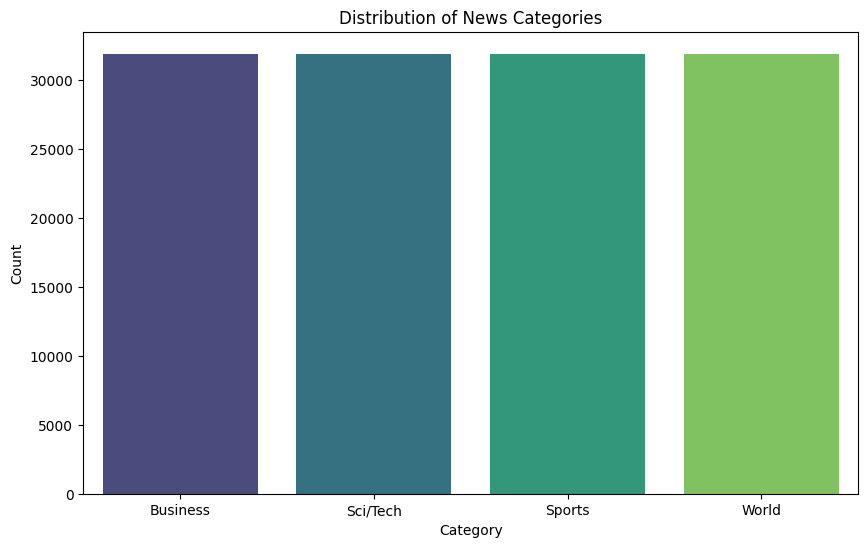

In [ ]:
# Ploting the distribution of news categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', palette='viridis')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

**Word Count Distribution**

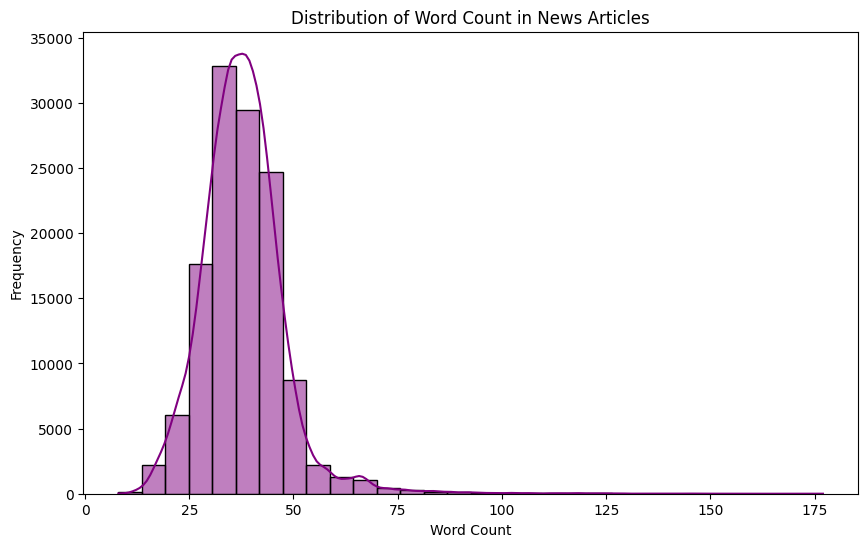

In [ ]:
# Adding a new column for word count
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Ploting the distribution of word counts
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], kde=True, bins=30, color='purple')
plt.title('Distribution of Word Count in News Articles')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


**Word Cloud for Each Category**

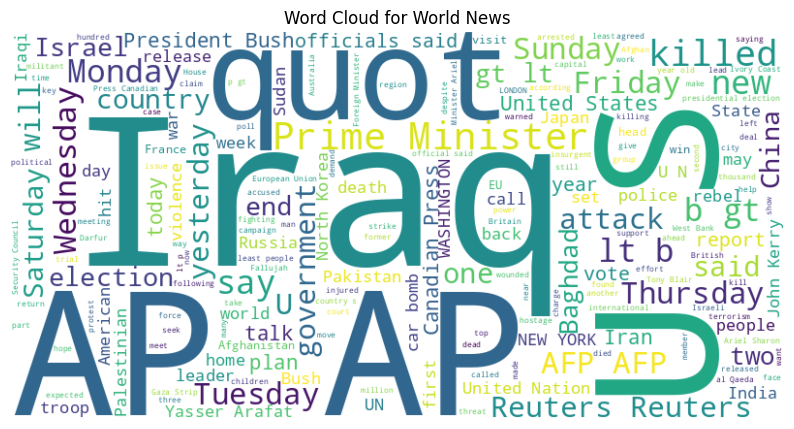

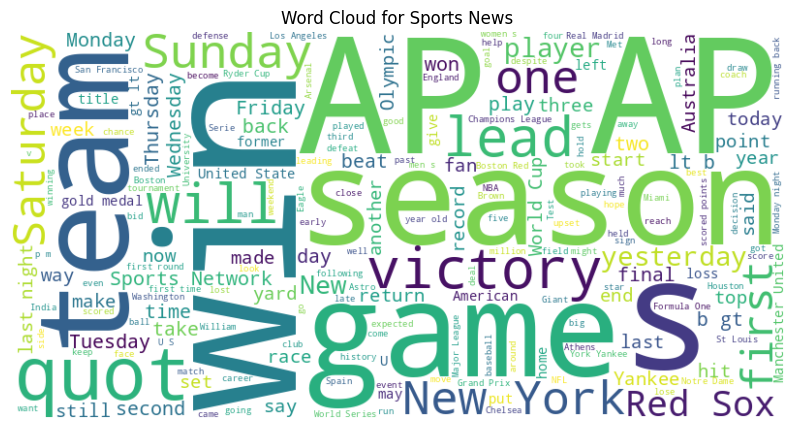

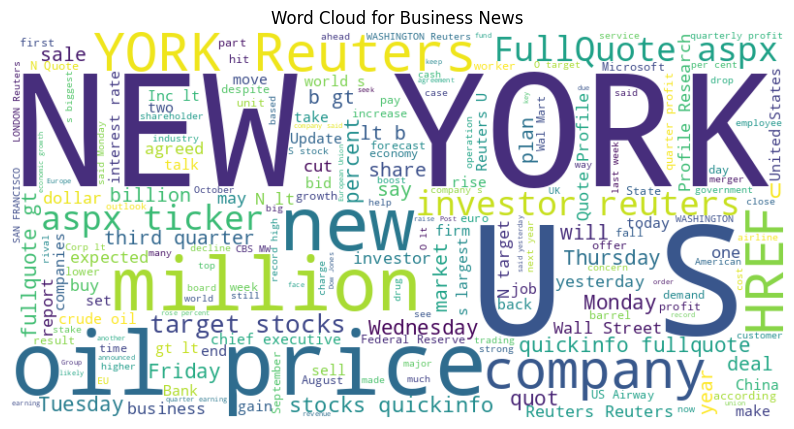

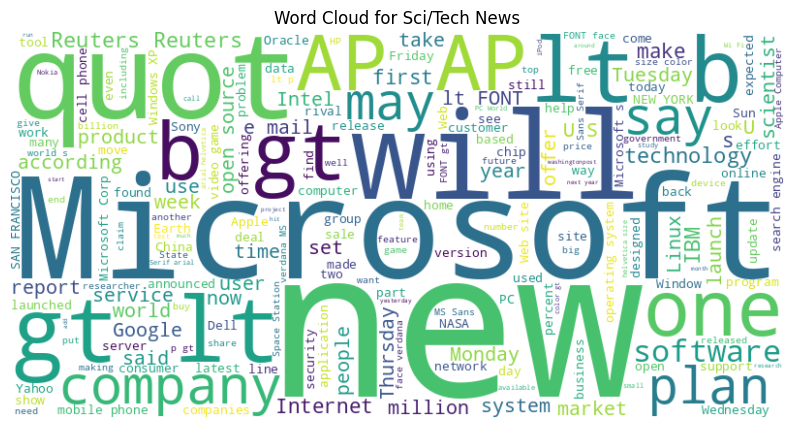

In [ ]:
from wordcloud import WordCloud

# Generating word clouds for each category
for label in label_mapping.values():
    text = " ".join(df[df['label'] == label]['text'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label} News')
    plt.axis('off')
    plt.show()


**Average Word Count per Category**

<ipython-input-33-e0b5b14b9faa>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_word_count.index, y=avg_word_count.values, palette='viridis')


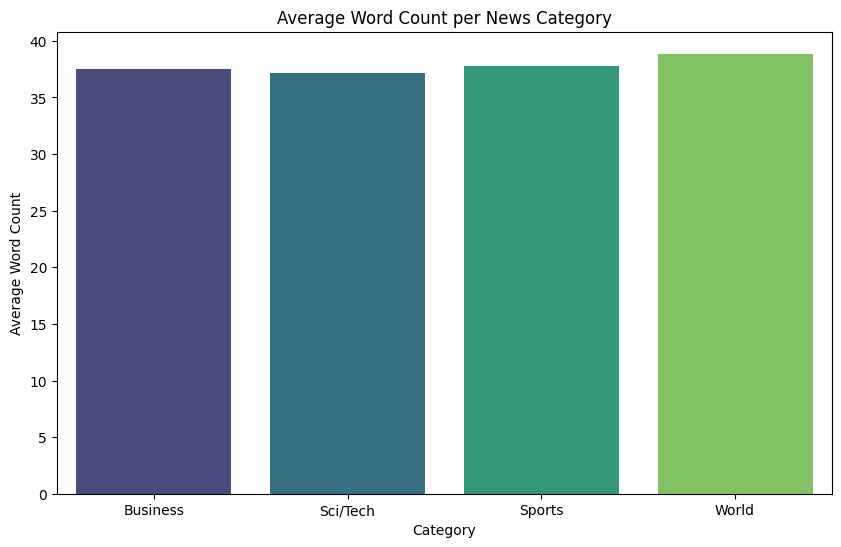

In [ ]:
# Group by label and calculate average word count
avg_word_count = df.groupby('label')['word_count'].mean()

# Ploting the average word count per category
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_word_count.index, y=avg_word_count.values, palette='viridis')
plt.title('Average Word Count per News Category')
plt.xlabel('Category')
plt.ylabel('Average Word Count')
plt.show()


**Prepraing model and training the model**

In [ ]:


# Spliting the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Loading the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing the text data
def tokenize_data(df, tokenizer):
    return tokenizer(
        df['text'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

# Tokenizing the training and validation data
train_encodings = tokenize_data(train_df, tokenizer)
val_encodings = tokenize_data(val_df, tokenizer)

# Encoding labels to tensor format
def encode_labels(df, label_mapping):
    return torch.tensor(df['label'].map({v: k for k, v in label_mapping.items()}).values)

train_labels = encode_labels(train_df, label_mapping)
val_labels = encode_labels(val_df, label_mapping)

# Creating a custom Dataset class
class AGNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: tensor[idx] for key, tensor in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Creating the PyTorch datasets
train_dataset = AGNewsDataset(train_encodings, train_labels)
val_dataset = AGNewsDataset(val_encodings, val_labels)

# Loading the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

# Moving model to the device
model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",  # Run evaluation at the end of each epoch
    fp16=True,  # GPU
    save_strategy="epoch",  # Save checkpoints at each epoch
    load_best_model_at_end=True,
)

# Define the metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'f1': f1, 'accuracy': acc}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Training the model
trainer.train()

# Saveing the trained model
trainer.save_model('./ag_news_model')


Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.330400,0.211739,0.938394,0.938636


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.330400,0.211739,0.938394,0.938636
2,0.105900,0.196064,0.947406,0.947414


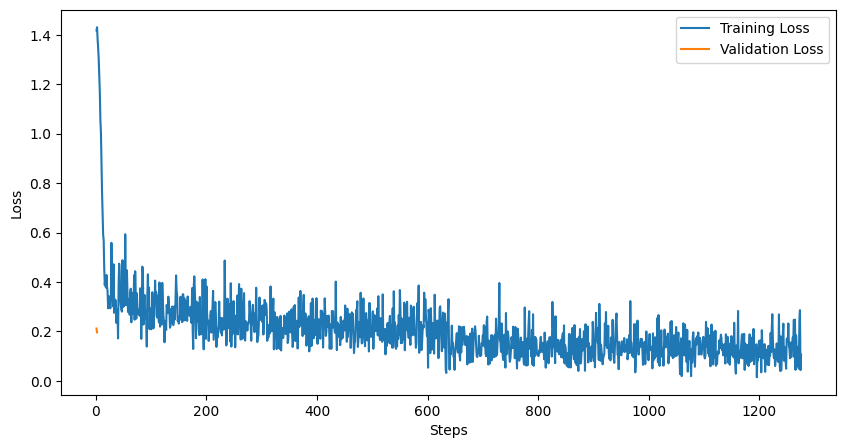

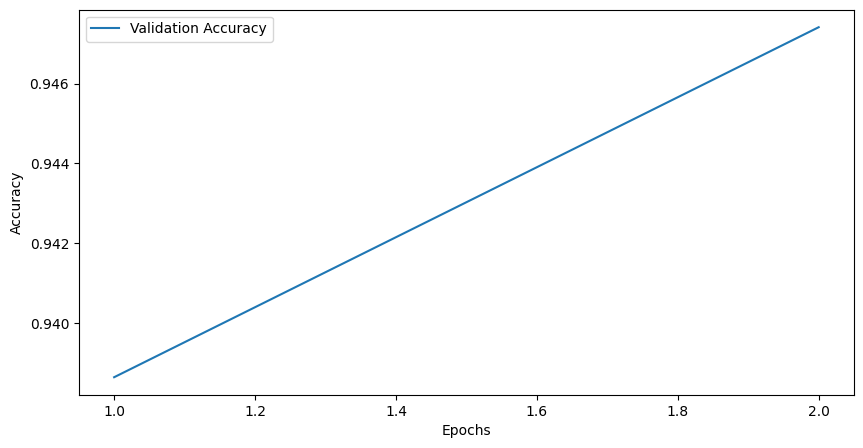

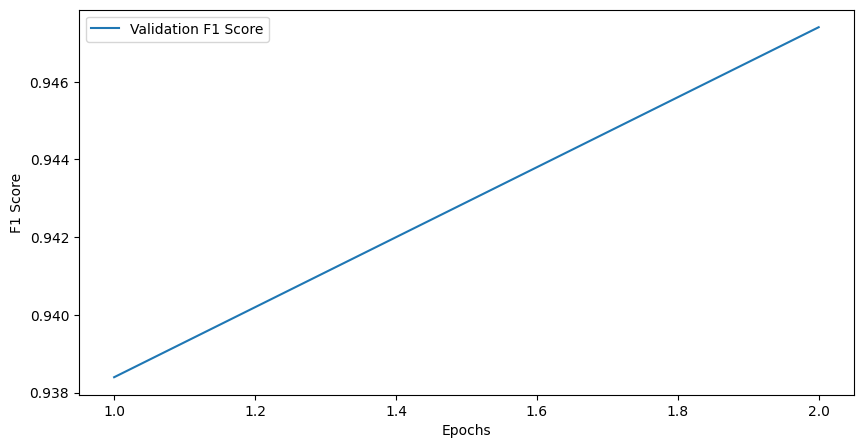

In [ ]:
# It will use all available steps of the model training
steps = range(1, len(train_loss) + 1)  # Use the length of train_loss as x-axis

# Ploting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Validation Loss')  # Eval loss might have fewer steps
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()


epochs = range(1, len(eval_accuracy) + 1)

# Ploting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Ploting validation F1 score
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_f1, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


Confusion Matrix

In [ ]:

# Geting predictions on the validation dataset
predictions = trainer.predict(val_dataset)

# Extracting true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = predictions.predictions.argmax(-1)


<Figure size 1000x1000 with 0 Axes>

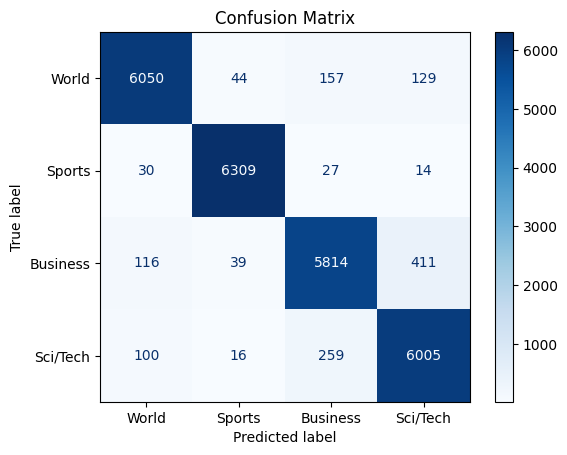

In [ ]:
# Generating the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.values())

# Ploting the confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



SAving model

In [ ]:
# Saving the trained model and tokenizer
model.save_pretrained('./ag_news_model')
tokenizer.save_pretrained('./ag_news_model')


('./ag_news_model/tokenizer_config.json',
 './ag_news_model/special_tokens_map.json',
 './ag_news_model/vocab.txt',
 './ag_news_model/added_tokens.json')

Downloading the model

In [ ]:


# Ziping the model directory
!zip -r ag_news_model.zip ./ag_news_model

# Downloading the zipped model
files.download('ag_news_model.zip')


  adding: ag_news_model/ (stored 0%)
  adding: ag_news_model/model.safetensors (deflated 7%)
  adding: ag_news_model/vocab.txt (deflated 53%)
  adding: ag_news_model/training_args.bin (deflated 51%)
  adding: ag_news_model/special_tokens_map.json (deflated 42%)
  adding: ag_news_model/config.json (deflated 52%)
  adding: ag_news_model/tokenizer_config.json (deflated 75%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Import necessary libraries
import shutil
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Zipping the model directory
!zip -r ag_news_model.zip ./ag_news_model

# Move the zipped model to Google Drive
shutil.move('ag_news_model.zip', '/content/drive/MyDrive/ag_news_model.zip')

print("Model successfully uploaded to Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
updating: ag_news_model/ (stored 0%)
updating: ag_news_model/model.safetensors (deflated 7%)
updating: ag_news_model/vocab.txt (deflated 53%)
updating: ag_news_model/training_args.bin (deflated 51%)
updating: ag_news_model/special_tokens_map.json (deflated 42%)
updating: ag_news_model/config.json (deflated 52%)
updating: ag_news_model/tokenizer_config.json (deflated 75%)
Model successfully uploaded to Google Drive.


**Deploying the model**

In [ ]:

# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained('./ag_news_model')
tokenizer = BertTokenizer.from_pretrained('./ag_news_model')

model.to(device)
model.eval()

# Define a prediction function
def predict(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the appropriate device
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    label = torch.argmax(probs, dim=1).item()
    return label_mapping[label], probs[0][label].item()

# Define the UI elements
text_input = widgets.Textarea(
    value='',
    placeholder='Enter news text here...',
    description='Input:',
    layout=widgets.Layout(width='70%', height='100px')
)

output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        text = text_input.value
        if text.strip() == "":
            print("Please enter some text!")
        else:
            label, confidence = predict(text)
            print(f"Predicted Category: {label} (Confidence: {confidence:.2f})")

# Create a button to trigger prediction
button = widgets.Button(description="Predict")
button.on_click(on_button_click)

# Display the UI
display(text_input, button, output)


Textarea(value='', description='Input:', layout=Layout(height='100px', width='70%'), placeholder='Enter news t…

Button(description='Predict', style=ButtonStyle())

Output()

In [ ]:
# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained('./ag_news_model')
tokenizer = BertTokenizer.from_pretrained('./ag_news_model')

model.to(device)
model.eval()

output = widgets.Output()
# Create a button to trigger prediction
button = widgets.Button(description="Predict")
button.on_click(on_button_click)

# Display the UI
display(text_input, button, output)


Textarea(value='this olympics china has the most gold medals', description='Input:', layout=Layout(height='100…

Button(description='Predict', style=ButtonStyle())

Output()

In [ ]:
output = widgets.Output()
# Create a button to trigger prediction
button = widgets.Button(description="Predict")
button.on_click(on_button_click)

# Display the UI
display(text_input, button, output)

Textarea(value='china has most gold medals in this olympics', description='Input:', layout=Layout(height='100p…

Button(description='Predict', style=ButtonStyle())

Output()